In [1]:
import config
import sqlalchemy
import functions
import statsapi as mlb
import sql_alch_schema
from datetime import datetime

In [2]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,DateTime,Date,Time,Boolean
from sqlalchemy import ForeignKey
from sqlalchemy.orm import relationship
from sqlalchemy.schema import Table
from sqlalchemy import distinct

In [3]:
_sql_alchemy_connection = (
                                f'mysql+mysqlconnector://'
                                f'{config.user}:{config.password}'
                                f'@{config.host}:{config.port}'
                                f'/{config.schema}'
                           )
## Create the engine 
db = sqlalchemy.create_engine(_sql_alchemy_connection,
                              echo = False,
                              connect_args = {'ssl_disabled' : True,})

In [4]:

Game = sql_alch_schema.Game
Play = sql_alch_schema.Play
Base = sql_alch_schema.Base
Team = sql_alch_schema.Team

from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=db)
session = Session()

## Create the teams table
We need teams before roster because we need to map the team id pk to team id fk in roster 

In [5]:
class GameTeamLink(Base):
    __tablename__ = 'game_team_link'
    __table_args__ = {'extend_existing': True}
    
    game_id = Column(String(150),ForeignKey('games.id'),primary_key=True)
    team_id = Column(Integer,ForeignKey('teams.id'),primary_key=True)
    
    # add roster at the time of game 
    player_1_id = Column(Integer)
    player_2_id = Column(Integer)
    player_3_id = Column(Integer)
    player_4_id = Column(Integer)
    player_5_id = Column(Integer)
    player_6_id = Column(Integer)
    player_7_id = Column(Integer)
    player_8_id = Column(Integer)
    player_9_id = Column(Integer)
    player_10_id = Column(Integer)
    player_11_id = Column(Integer)
    player_12_id = Column(Integer)
    player_13_id = Column(Integer)
    player_14_id = Column(Integer)
    player_15_id = Column(Integer)
    player_16_id = Column(Integer)
    player_17_id = Column(Integer)
    player_18_id = Column(Integer)
    player_19_id = Column(Integer)
    player_20_id = Column(Integer)
    player_21_id = Column(Integer)
    player_22_id = Column(Integer)
    player_23_id = Column(Integer)
    player_24_id = Column(Integer)
    player_25_id = Column(Integer)
    player_26_id = Column(Integer)
    player_27_id = Column(Integer)
    player_28_id = Column(Integer)
    player_29_id = Column(Integer)
    player_30_id = Column(Integer)
    player_31_id = Column(Integer)
    player_32_id = Column(Integer)
    player_33_id = Column(Integer)
    player_34_id = Column(Integer)
    player_35_id = Column(Integer)
    player_36_id = Column(Integer)
    player_37_id = Column(Integer)
    player_38_id = Column(Integer)
    player_39_id = Column(Integer)
    player_40_id = Column(Integer)
    
    #relationships
    game = relationship('Game',back_populates='teams')
    team = relationship('Team',back_populates='games')

# update game and team tables 
Game.teams = relationship("GameTeamLink",back_populates='game')
Team.games = relationship("GameTeamLink",back_populates='team')

In [6]:
def players(self):
    for attr, value in self.__dict__.items():
        if attr.startswith("player") and value >0:
            yield value
GameTeamLink.players = players

In [7]:
def gtl__repr__(self):
    return "<GameTeam(game_id='%s',team_id='%s')>" % (
                        self.game_id,self.team_id)
GameTeamLink.__repr__ = gtl__repr__

In [8]:
#db.execute('drop table game_team_link')
Base.metadata.create_all(db)

## Query the db to get info needed for roster table

to get the active roster from the mlb stats api, I need a team id, season, and date 

In [9]:
def get_roster_inputs(query):   
    roster_inputs = []
    for instance in query.all():
        roster_input_dict = {'date':datetime.strftime(instance.dateTime,'%Y-%m-%d'),
                             'season':instance.season,
                             'homeTeam':instance.homeTeam_id,
                             'awayTeam':instance.awayTeam_id,
                             }
        roster_inputs.append(roster_input_dict)
        
    return roster_inputs
    

In [10]:
def get_roster(roster_input_dict):
    #player_list = ['player_'+str(x) for x in range(1,41)]
    home = mlb.get('team_roster',
                   {'teamId':roster_input_dict['homeTeam'],
                    'rosterType':'active',
                    'season':roster_input_dict['season'],
                    'date':roster_input_dict['date']
                   })['roster']
    home_roster_ids = [x['person']['id'] for x in home]
    player_list = ['player_'+str(x) for x in range(1,len(home_roster_ids)+1)]
    home_roster_dict = {x:y for x,y in zip(player_list,home_roster_ids)}
    home_roster_dict['teamId'] = roster_input_dict['homeTeam']
    
    away = mlb.get('team_roster',
                   {'teamId':roster_input_dict['awayTeam'],
                    'rosterType':'active',
                    'season':roster_input_dict['season'],
                    'date':roster_input_dict['date']
                   })['roster']
    away_roster_ids = [x['person']['id'] for x in away]
    player_list = ['player_'+str(x) for x in range(1,len(away_roster_ids)+1)]
    away_roster_dict = {x:y for x,y in zip(player_list,away_roster_ids)}
    away_roster_dict['teamId']=roster_input_dict['awayTeam']
    return home_roster_dict,away_roster_dict


In [11]:
def create_GameTeamLink(game_ids):
    records = []
    for game_id in game_ids:
        game_query = session.query(Game).filter_by(id=game_id)
        roster_input_dicts = get_roster_inputs(game_query)
        home_roster,away_roster = get_roster(roster_input_dicts[0])
        rosters = [home_roster,away_roster]
#       rosters.append(roster)
        
        for roster in rosters:
            game_team_record = GameTeamLink(game_id=game_id,
                                            team_id=roster['teamId'],

                                            player_1_id = roster.get('player_1','null'),
                                            player_2_id = roster.get('player_2','null'),
                                            player_3_id = roster.get('player_3','null'),
                                            player_4_id = roster.get('player_4','null'),
                                            player_5_id = roster.get('player_5','null'),
                                            player_6_id = roster.get('player_6','null'),
                                            player_7_id = roster.get('player_7','null'),
                                            player_8_id = roster.get('player_8','null'),
                                            player_9_id = roster.get('player_9','null'),
                                            player_10_id = roster.get('player_10','null'),
                                            player_11_id = roster.get('player_11','null'),
                                            player_12_id = roster.get('player_12','null'),
                                            player_13_id = roster.get('player_13','null'),
                                            player_14_id = roster.get('player_14','null'),
                                            player_15_id = roster.get('player_15','null'),
                                            player_16_id = roster.get('player_16','null'),
                                            player_17_id = roster.get('player_17','null'),
                                            player_18_id = roster.get('player_18','null'),
                                            player_19_id = roster.get('player_19','null'),
                                            player_20_id = roster.get('player_20','null'),
                                            player_21_id = roster.get('player_21','null'),
                                            player_22_id = roster.get('player_22','null'),
                                            player_23_id = roster.get('player_23','null'),
                                            player_24_id = roster.get('player_24','null'),
                                            player_25_id = roster.get('player_25','null'),
                                            player_26_id = roster.get('player_26','null'),
                                            player_27_id = roster.get('player_27','null'),
                                            player_28_id = roster.get('player_28','null'),
                                            player_29_id = roster.get('player_29','null'),
                                            player_30_id = roster.get('player_30','null'),
                                            player_31_id = roster.get('player_31','null'),
                                            player_32_id = roster.get('player_32','null'),
                                            player_33_id = roster.get('player_33','null'),
                                            player_34_id = roster.get('player_34','null'),
                                            player_35_id = roster.get('player_35','null'),
                                            player_36_id = roster.get('player_36','null'),
                                            player_37_id = roster.get('player_37','null'),
                                            player_38_id = roster.get('player_38','null'),
                                            player_39_id = roster.get('player_39','null'),
                                            player_40_id = roster.get('player_40','null')
                                           )
            records.append(game_team_record)
    return records

A Game record queried from mysql has a .teams attribute that retuns two GameTeamLink records as shown below

In [12]:
test_gameId = '2019/03/28/anamlb-oakmlb-1'
game_test = session.query(Game).filter_by(id=test_gameId).one()

print(game_test)
game_test.teams

<Game(pk='566086',id='2019/03/28/anamlb-oakmlb-1')>


[<GameTeam(game_id='2019/03/28/anamlb-oakmlb-1',team_id='108')>,
 <GameTeam(game_id='2019/03/28/anamlb-oakmlb-1',team_id='133')>]

A game_team object can access the associated game record and team record as well as plays for that game

In [13]:
game_team_test = game_test.teams[0]

print(game_team_test,'\n')
print(game_team_test.team,'\n')
print(game_team_test.player_1_id,'\n')
game_team_test.game.plays

<GameTeam(game_id='2019/03/28/anamlb-oakmlb-1',team_id='108')> 

<Team(name='Los Angeles Angels')> 

405395 



[<Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='0')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='1')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='10')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='11')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='12')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='13')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='14')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='15')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='16')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='17')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='18')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='19')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='2')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='20')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='21')>,
 <Play(game_id='2019/03/28/anamlb-oakmlb-1',atBatIndex='22

we can also access players through a game_team_object

In [14]:
[x for x in game_team_test.players()]==[x for x in game_team_test.players()][0:None]

True

In [15]:
game_test.teams[0].players()

<generator object players at 0x110751570>

## I need to create and add game_team records for every game now
- find all game_ids
- find game_ids for all currently present game_team records 
- create records for all game_ids not currently present
- session.add() session.commit()

In [16]:
def chunk(n,list_to_chunk):
    return [ list_to_chunk[i:i+n] for i in range(0,len(list_to_chunk),n) ]

def create_add_GameTeamLink(session,start=0,stop=None,chunk_size=50):   
    # collect game_ids from the games table 
    ids_list_test = session.query(Game.id).all()[start:stop]
    ids_list_test=[item for sublist in ids_list_test for item in sublist]

    # collect game_ids from the game_link table
    # I'll naturally have duplicates so I think I'll make it a set 
    already_added = list({item for sublist in session.query(GameTeamLink.game_id).all() for item in sublist})

    games_to_get = [game for game in ids_list_test if game not in already_added]
    
    list_of_chunks = chunk(chunk_size,games_to_get)
    count = 1
    
    for _chunk in list_of_chunks:
        try:
            print(f'starting chunk {count} out of {len(list_of_chunks)}')
            games_teams_to_add = create_GameTeamLink(_chunk)

            session.add_all(games_teams_to_add)
            session.commit()

            count = count+1
        except:
            print('chunk failed. Rolling back the session and trying the next chunk')
            session.rollback()
            continue 

In [80]:
create_add_GameTeamLink(session)


starting chunk 1 out of 47
starting chunk 2 out of 47
starting chunk 3 out of 47
starting chunk 4 out of 47
starting chunk 5 out of 47
starting chunk 6 out of 47
starting chunk 7 out of 47
starting chunk 8 out of 47
starting chunk 9 out of 47
starting chunk 10 out of 47
starting chunk 11 out of 47
starting chunk 12 out of 47
starting chunk 13 out of 47
starting chunk 14 out of 47
starting chunk 15 out of 47
starting chunk 16 out of 47
starting chunk 17 out of 47
starting chunk 18 out of 47
starting chunk 19 out of 47
starting chunk 20 out of 47
starting chunk 21 out of 47
starting chunk 22 out of 47
starting chunk 23 out of 47
starting chunk 24 out of 47
starting chunk 25 out of 47
starting chunk 26 out of 47
starting chunk 27 out of 47
starting chunk 28 out of 47
starting chunk 29 out of 47
starting chunk 30 out of 47
starting chunk 31 out of 47
starting chunk 32 out of 47
starting chunk 33 out of 47
starting chunk 34 out of 47
starting chunk 35 out of 47
starting chunk 36 out of 47
s

## Let's find some player stats
Eventually, we want team stats. But lets start with a single player

In [17]:
mike_trout_id = 545361

In [18]:
# look at all possible values for the event from a play 
play_events = [item for sublist in session.query(distinct(Play.event)).all() for item in sublist]

In [19]:
play_events

['Double',
 'Hit By Pitch',
 'Strikeout',
 'Lineout',
 'Home Run',
 'Flyout',
 'Groundout',
 'Single',
 'Pop Out',
 'Forceout',
 'Field Error',
 'Double Play',
 'Sac Fly',
 'Walk',
 'Bunt Groundout',
 'Triple',
 'Grounded Into DP',
 'Caught Stealing 2B',
 'Sac Bunt',
 'Strikeout Double Play',
 'Catcher Interference',
 'Fielders Choice',
 'Fielders Choice Out',
 'Runner Out',
 'Batter Interference',
 'Fan Interference',
 'Intent Walk',
 'Sac Fly Double Play',
 'Pickoff 1B',
 'Bunt Pop Out',
 'Pickoff Caught Stealing 2',
 'Caught Stealing Home',
 'Bunt Lineout',
 'Game Advisory',
 'Batter Out',
 'Pickoff Caught Stealing 3',
 'Caught Stealing 3B',
 'Pickoff Caught Stealing H',
 'Runner Double Play',
 'Pickoff 2B',
 'Wild Pitch',
 'Pickoff 3B',
 'Triple Play',
 'Sac Bunt Double Play',
 'Passed Ball',
 'Stolen Base 2B',
 'Pickoff Error 1B']

In [76]:
hits = [
    'Single',
    'Double',
    'Triple',
    'Home Run',
]

In [21]:
# how many hits did Mike Trout have in 2019? 
from sqlalchemy import and_
mike_trout_hits = session.query(Play).filter(and_(Play.batter_id==mike_trout_id,Play.event.in_(hits))).count()
mike_trout_abs = session.query(Play).filter(and_(Play.batter_id==mike_trout_id)).count()

In [22]:
mike_trout_avg = mike_trout_hits/mike_trout_abs

In [23]:
first_play = session.query(Play).first()

In [24]:
first_play.game.type

'S'

In [50]:
PAs = []
for game, play in session.query(Game,Play).\
                    filter(Game.id==Play.game_id).\
                    filter(and_(Game.type=='R',Game.dateTime<datetime(2019,7,1))).\
                    filter(Play.batter_id==mike_trout_id).\
                    all():
    PAs.append(play)
    

In [53]:
len([x for x in PAs if x.event in hits])

82

In [54]:
len(PAs)

361

In [114]:
def player_hits(session,player_id,game_record=None,date=None):
    """
    function takes in sql alchemy session, an instance of the Game class, and a player id.
    returns player stats up until the date of the relevant game.
    """
    if game_record==None and date==None:
        print('error: must specify a game or date')
    elif game_record!=None and date!=None:
        print('error: must specify either a date or a game. not both')
    else:
        if game_record:
            date = game_record.dateTime
        else:
            date=date
        PAs = []
        for game, play in session.query(Game,Play).\
                        filter(Game.id==Play.game_id).\
                        filter(and_(Game.type=='R',Game.dateTime<date)).\
                        filter(Play.batter_id==player_id).\
                        all():
            PAs.append(play)
        player_hits = [x for x in PAs if x.event in hits]
#     print('Plate Appearances: ',len(PAs))
#     print('Hits: ', len(player_hits))
        return len(player_hits)

In [115]:
game_record_test = session.query(Game).filter(Game.dateTime<datetime(2019,6,3)).all()[-1]
player_hits(session,mike_trout_id,game_record=game_record_test)

52

Plot cumulative hits for a player

In [97]:
import matplotlib.pyplot as plt

In [129]:
ordered_games = session.query(Game).filter(Game.type=='R').order_by(Game.dateTime).all()

In [152]:
# adding a game_players method to the Games table to return a list of active player ids
def game_players(self):
    return [x.players() for x in self.teams]

Game.game_players = game_players

# adding another Game method to see all players in a game
def all_players(self):
    return [item for sublist in self.game_players() for item in sublist]

Game.all_players = all_players

In [164]:
trout_PAs = session.query(Play).filter(Play.batter_id==mike_trout_id).all()

In [180]:
trout_hit_dict = [{'time':x.startTime,'event':x.event} for x in trout_PAs if x.event in hits]

In [186]:
trout_hit_dates = [x['time'] for x in trout_hit_dict if x]
trout_hit_dates.sort()
trout_hit_dates = trout_hit_dates[1:]

In [188]:
count = 1
trout_cum_hits = []
for hit_date in trout_hit_dates:
    trout_cum_hits.append({'date':hit_date,'cum_hits':count})
    count+=1

In [191]:
dates = [x['date'] for x in trout_cum_hits]
cum_hits = [x['cum_hits'] for x in trout_cum_hits]

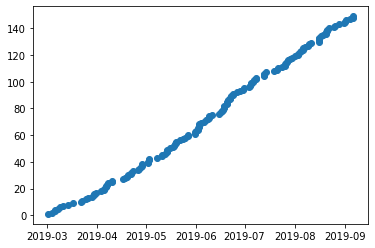

In [192]:
plt.plot_date(x=dates,y=cum_hits,xdate=True)